In [1]:
import os
os.chdir('/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd/')

import dLux as dl
import matplotlib.pyplot as plt
import dLuxToliman as dlT
from matplotlib import colors
from jax import numpy as np

from dLux.detector_layers import DetectorLayer
from jax import Array
from jax.scipy.stats import multivariate_normal

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "monospace"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

In [28]:
Image = lambda: dl.images.Image

class ApplyAsymmetricJitter(DetectorLayer):
    
    kernel_size: int
    cov: Array

    def __init__(self: DetectorLayer, cov: Array, kernel_size: int = 10):
        """
        Constructor for the ApplyJitter class.

        Parameters
        ----------
        cov : Array, pixels
            The covariance matrix of the Gaussian kernel, in units of arcseconds.
        kernel_size : int = 10
            The size of the convolution kernel in pixels to use.
        """
        super().__init__()
        self.kernel_size = int(kernel_size)
        self.cov = np.asarray(cov, dtype=float)
        if self.cov.shape != (2, 2):
            raise ValueError('Covariance matrix must be 2x2.')

    def generate_kernel(self, pixel_scale: float) -> Array:
        """
        Generates the normalised Gaussian kernel.
    
        Parameters
        ----------
        pixel_scale : float, arcsec/pixel
            The pixel scale of the image.

        Returns
        -------
        kernel : Array
            The normalised Gaussian kernel.
        """
        # Generate distribution
        extent = pixel_scale * self.kernel_size
        x = np.linspace(0, extent, self.kernel_size) - 0.5*extent
        xs, ys = np.meshgrid(x, x)
        pos = np.dstack((xs, ys))

        kernel = multivariate_normal.pdf(pos, mean=np.array([0., 0.]), cov=self.cov)

        return kernel / np.sum(kernel)

    def __call__(self: DetectorLayer, image: Image()) -> Image():
        """
        Applies the layer to the Image.

        Parameters
        ----------
        image : Image
            The image to operate on.

        Returns
        -------
        image : Image
            The transformed image.
        """
        kernel = self.generate_kernel(dl.utils.rad_to_arcsec(image.pixel_scale))

        return image.convolve(kernel)

In [79]:
pscale = .375  # arcsec/pixel
det_npix = 128
oversample = 4
wf_npixels = 512
kernel_size = 20
covariance_matrix = 0.05*np.array([[1, 0], [0, 1]])

In [81]:
src = dlT.AlphaCen()
osys = dlT.TolimanOptics(wf_npixels=512, psf_pixel_scale=pscale, psf_oversample=oversample, psf_npixels=det_npix*oversample)
det = dl.LayeredDetector([
    (ApplyAsymmetricJitter(cov=covariance_matrix, kernel_size=kernel_size), 'Jitter'),
    (dl.IntegerDownsample(oversample), 'Downsample'),
])

tel = dl.Instrument(sources=src, optics=osys, detector=det)

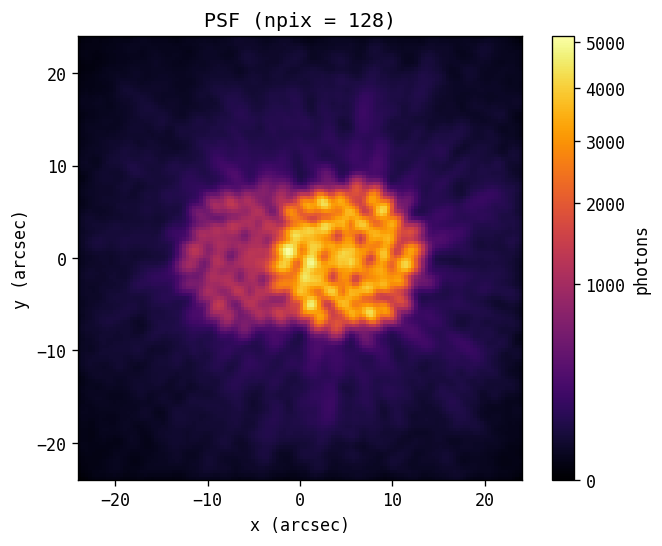

In [78]:
PSF = tel.model()

l = PSF.shape[0] / 2

fig, ax = plt.subplots()
im = ax.imshow(PSF,
               cmap='inferno',
               norm=colors.PowerNorm(gamma=0.5),
               extent=pscale*np.array([-l, l, -l, l]),
               )
fig.colorbar(im, ax=ax, label='photons')
ax.set(
        title='PSF (npix = {})'.format(det_npix),
        xlabel='x (arcsec)',
        ylabel='y (arcsec)',
        )
plt.show()